In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import torchvision

import sys, os
sys.path.append(os.path.join(os.path.dirname("./"), '..'))

from Models.ResNet import ResNet18
from utils.Training import Train
from utils.CustomDataset import CustomDataset

In [2]:
# Loading the data
TestData, TestLabels = [], []
TrainData, TrainLabels = [], []

LabelToId = {'no': 0, 'sphere':1, 'vort':2}

# Walking through the train directory and loading the data
for root, dirs, files in os.walk("../dataset/DatasetTask1/train"):
    for dir in dirs:
        for root2, dirs2, files2 in os.walk(os.path.join(root, dir)):
            for file in files2:
                TrainData.append(( file ))
                TrainLabels.append(dir)

# Walking through the test directory and loading the data
for root, dirs, files in os.walk("../dataset/DatasetTask1/val"):
    for dir in dirs:
        for root2, dirs2, files2 in os.walk(os.path.join(root, dir)):
            for file in files2:
                TestData.append(file)
                TestLabels.append(dir)

ImageTransforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
])

one_hot_transform = transforms.Lambda(
    lambda y: torch.nn.functional.one_hot(torch.tensor(y, dtype=torch.long), num_classes=3)
)

TrainDataset = CustomDataset(
    root="../dataset/DatasetTask1/train",
    data=TrainData,
    label=TrainLabels,
    label_to_id=LabelToId,
    transforms=ImageTransforms,
    label_transform=one_hot_transform
)

TestDataset = CustomDataset(
    root="../dataset/DatasetTask1/val/",
    data=TestData,
    label=TestLabels,
    label_to_id=LabelToId,
    transforms=None,
    label_transform=one_hot_transform
)

In [3]:
TrainDataset[0][1]

/Users/mandakausthubh/Ghost/MachineLearning/Projects/GSOC2025Tests/Task-1-Training-and-Results/../utils/CustomDataset.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, dtype=torch.float32), torch.nn.functional.one_hot(torch.tensor(label), num_classes=len(self.label_to_id)).float()


tensor([0., 0., 1.])

In [4]:
np.unique(TrainLabels, return_counts=True), np.unique(TestLabels, return_counts=True)

((array(['no', 'sphere', 'vort'], dtype='<U6'), array([10000, 10000, 10000])),
 (array(['no', 'sphere', 'vort'], dtype='<U6'), array([2500, 2500, 2500])))

In [5]:
# Splitting and creating the dataset into training and validation
TrainLen = int(0.9 * len(TrainDataset))
ValLen = len(TrainDataset) - TrainLen

TrainDataset, ValidationDataset = random_split(TrainDataset, lengths=[TrainLen, ValLen])

In [6]:
len(TrainDataset), len(ValidationDataset), len(TestDataset)

(27000, 3000, 7500)

In [7]:
TrainLoader = DataLoader(TrainDataset, batch_size=32, shuffle=True)
ValidationLoader = DataLoader(ValidationDataset, batch_size=32, shuffle=True)
TestLoader = DataLoader(TestDataset, batch_size=32, shuffle=True)

In [8]:
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.mps.is_available():
    device = torch.device("mps")   # I have a MacBook hence this option


# Building the model: 
model1 = ResNet18(input_size=150, in_channels= 1, num_classes= 3).to(device)

print(f"Using device: {device}")

Using device: mps


In [9]:
model1(torch.randn(75, 1, 150, 150).to(device)).shape
for images, labels in TrainLoader:
    print(images.shape)
    print(labels.shape)

    print(model1(images.to(device)).shape)
    break

torch.Size([32, 1, 150, 150])
torch.Size([32, 3])
torch.Size([32, 3])


In [10]:
LossFunc = nn.CrossEntropyLoss()
Optimizer = torch.optim.Adam(model1.parameters(), lr=1e-4)

Train(model1, TrainLoader, ValidationLoader, LossFunc, Optimizer, 90, device)
# Experimented with different number of epoch scores to get this output.

Validation: 100%|██████████| 94/94 [00:04<00:00, 22.62it/s, accuracy=0.75, loss=0.797] 

Finished Training


In [11]:
torch.save(model1, "../ModelWeights/ResNet18.pth")

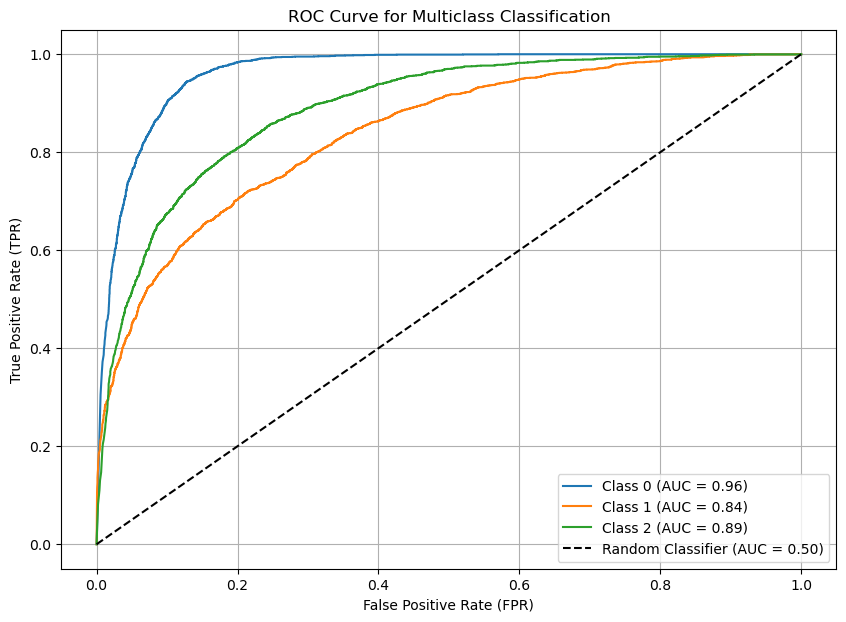

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_multiclass_roc(y_true, y_pred, num_classes):
    y_true_one_hot = label_binarize(y_true, classes=np.arange(num_classes))

    plt.figure(figsize=(10, 7))

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")
    
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve for Multiclass Classification")
    plt.legend()
    plt.grid()
    plt.show()


def evaluate_model_roc(model, dataloader, device, num_classes):
    model.eval()  # Set model to evaluation mode
    y_true_list = []
    y_pred_list = []

    with torch.no_grad(): 
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            logits = model(images) 
            
            y_true_list.append(labels.cpu().numpy())
            y_pred_list.append(logits.cpu().numpy())

    y_true = np.concatenate(y_true_list, axis=0)
    y_pred = np.concatenate(y_pred_list, axis=0)

    plot_multiclass_roc(y_true, y_pred, num_classes)

evaluate_model_roc(model1, TestLoader, device, num_classes=3)